### An example for a 2D dataset classification by nerual networks 

We partition a 2D domain, $D$, into $m$ subdomains $D_i$ for $i=1,2,\ldots, m$ such that
\begin{equation}
  D = \bigcup_{i=1}^{m} D_i, \quad D_i \cap D_j = \emptyset \mbox{ for } i\neq j,
\label{partition} \tag{1}
\end{equation}
We then define a function, $f^*: D \subset R^d \rightarrow R$, by
$$        f^*(\mathbf{x}) = \alpha_i, \quad \mathbf{x} \in D_i \quad \mbox{for } i=1,2,\ldots, m. $$

One typical data classification problem is to learn the domain partition \eqref{partition} from a given dataset, ${\cal D}_i$, satisfying that
\begin{equation}
  {\cal D}= \bigcup_{i=1}^{m} {\cal D}_i, \quad {\cal D}_i \cap {\cal D}_j = \emptyset \mbox{ for } i\neq j,
\label{partitionData} \tag{2}
\end{equation}
where ${\cal D}_i$ is a set of pairs $(\mathbf{x}, y)$ with $\mathbf{x}\in D_i$ and $y=\alpha_i$.

In this example, we set $d=2$ and generate the dataset ${\cal D}$ using $m$ spiral curves defined as follows:

1. Partition the interval $[0, 2\pi]$ into $m$ subintervals $[(i-1)\tau, i \tau]$ for $i=1,2,\ldots, m$. Here $\tau=2\pi/m$, which is the length of each subinterval. 
2. Let $0\leq t \leq 1$ and generate $N$ numbers $t_j = j/N$ for $j=0, 1, \ldots, N$.
3. Let $\theta(t) = (i-1)\tau + \tau t$ for $0\leq t \leq 1$ such that $\theta(t) \in [(i-1)\tau, i \tau]$ and generate $N$ numbers $\theta_j = (i-1)\tau + \tau t_j$ for $j=0, 1, \ldots, N$.
4. Define the $i$th spiral curve on the subintervals $[(i-1)\tau, i \tau]$ by the parameter equations:
\begin{align}
   x_1 &= t \sin(\tau(t+i-1)), \\
   x_2 &= t \cos(\tau(t+i-1)), \quad t\in [0, 1] \mbox{ for } i=1,2, \ldots, m,
\label{spiralEqs} \tag{3}
\end{align}
where $t$ is the parameter and $\mathbf{x}=(x_1, x_2) \in D_i \subset R^2$. 
5. We generate $N$ points $\mathbf{x}_j =(x_{j1}, x_{j2}) \in D_i$ for $i=1,2, \ldots, m$ by 
\begin{align}
   x_{j1} &= t_j \sin(\tau(t_j+i-1)), \\
   x_{j2} &= t_j \cos(\tau(t_j+i-1)) \quad \mbox{with $t_j=j/N$ for } j=0, 1, 2, \ldots,N, 
\label{spiralData} \tag{4}
\end{align}
resulting in the $i$th dataset ${\cal D}_i =\{ (\mathbf{x}_j, y_j) | j=0, 1, 2, \ldots,N \}$ with $y_j=i$. 

### Note: 

- In the program, we set $\theta = \tau(t+i)$ for $i=0, 1, 2, \ldots, m-1$ for $\theta \in [\tau i, \tau (i+1)]$. We then generate a uniform partition of this interval with $\theta_j = \tau(t_j+i)$ for $j=0, 1, 2, \ldots, N$. 
- This notebook is a modified version of the notebook from the NYU deep learning course. See the link for more information: [https://atcold.github.io/pytorch-Deep-Learning/en/week02/02-3/](https://atcold.github.io/pytorch-Deep-Learning/en/week02/02-3/). 
- Dr. Dexuan Xie on Oct. 21, 2021 for Math 801: Add the construction part of the datasets and make some changes to match the description given here.


In [1]:
import random
import torch
from torch import nn, optim
import math
from IPython import display
from matplotlib import pyplot as plt
import numpy as np

import time

In [2]:
def set_default(figsize=(10, 10), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)


def plot_data(X, y, d=0, auto=False, zoom=1):
    X = X.cpu()
    y = y.cpu()
    # Use c = y to color each point
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y, s=20, cmap=plt.cm.Spectral)
    plt.axis('square')
    plt.axis(np.array((-1.1, 1.1, -1.1, 1.1)) * zoom)
    if auto is True: plt.axis('equal')
    #plt.axis('off')

    _m, _c = 0, '.15'
    plt.axvline(0, ymin=_m, color=_c, lw=1, zorder=0)
    plt.axhline(0, xmin=_m, color=_c, lw=1, zorder=0)

def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plot_data(X, y)
    
def plot_model2(X, y, model, r2 = 5, step = 10):
    """
    Plot the subdomain partition predicted by the neuaral network
    """
    model.cpu()
    mesh = np.arange(-r2 -0.5, r2 + 0.5, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    # Plot the sample points of each subdomain
    # plt.scatter(X.numpy()[:-1:step, 0], X.numpy()[:-1:step, 1], c=y[:-1:step], s=20, cmap=plt.cm.Spectral)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.3)
    plt.ylabel('$x_2$')
    plt.xlabel('$x_1$')
    plt.title('Predicted domain partiton')

### Implement a Modified Activation Function


One of the examples of such simple functions is Sigmoid Linear Unit or just SiLU also known as Swish-1:

   S𝑖𝐿𝑈(𝑥)= x / (1 + exp(x))


In [3]:
# Set the figure ploting parameters by using the defaults given in set_default()
set_default()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Generate the training data set that contains $m$ subclasses.

In [4]:
# Set a seed for the random number generator
seed = 12345
random.seed(seed)
torch.manual_seed(seed)

# Input parameters.
N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
m = 3  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
noice = 0.4 # noice rate

# Allocation of the memories 
#  X: a 2D array for the matrix of order NC x D
#  y: a 1D array for the vector of order NC
X = torch.zeros(N * m, D).to(device)
y = torch.zeros(N * m, dtype=torch.long).to(device)

# Generate a uniform partition of interval [0, 1] for parameter variable t
#  t_j = j/N for j=0, 1, 2, ..., N
t = torch.linspace(0, 1, N)

# Length of each subinterval 
tau = 2 * math.pi / m

In [5]:
# Generate the m sub-datasets such that each subdata set contains N sample points
for i in range(m):  # Here i = 0, 1, 2, ..., m-1
    j = 0
    # Generate N numbers in the subinterval [tau*i, tau*(i+1)] with tau = 2pi/C
    theta = torch.linspace(tau * i, tau * (i + 1), N) + torch.randn(N) * noice
    # Generate the N sample points in the $i$th subdomain D_i
    for ix in range(N * i, N * (i + 1)):
        X[ix] = t[j] * torch.FloatTensor((
            math.sin(theta[j]), math.cos(theta[j])
        ))
        y[ix] = i
        j += 1

print("Shapes:")
print("X:", tuple(X.size()))
print("y:", tuple(y.size()))
#print('y=', y)
#print('X=', X)

Shapes:
X: (1500, 2)
y: (1500,)


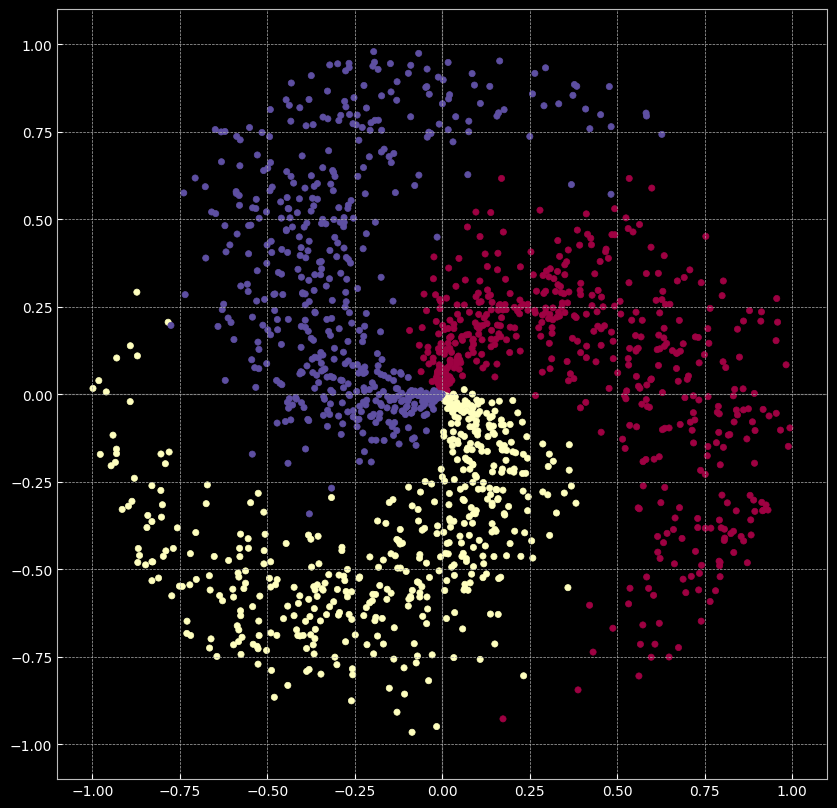

In [6]:
# visualise the data
plot_data(X, y)

### Linear model

[Linear model in PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) defines a linear transformation to the incoming data vector $x$ by
$$  y = xA^T + b,$$
where $y\in R^l$,  $x\in R^d$, $A$ is a matrix of $l\times d$, and $b\in R^l$. Here $n$ denotes as in_features, $l$ denotes as out_features. We need to determine the weight matrix $A$ and bias vector $b$ optimally by minimizing a loss function  $L(A, b)$.

Example:

```
CLASS torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)

>>> in_features = 20   # d=20
>>> out_features = 30  # l = 30
>>> m = nn.Linear(in_features, out_features)
>>> input = torch.randn(128, in_features)  # input is a training data set as an array of N x d. 
                                           #    N is the number of points (x,y)
>>> output = m(input)   # output is the predicted function values: 
                        #         output = (y_1, y_2, ..., y_N) with y_i in R^l
>>> print(output.size())
torch.Size([128, 30])
```

In [7]:
learning_rate = 1e-3
lambda_l2 = 1e-5

In [9]:
activation_function = nn.ReLU()

# nn package to create our linear model
# each Linear module has a weight and bias
linear_model = nn.Sequential(
    # A single layer perceptron
    nn.Linear(D, m)
    # A multipler layer perceptron with two hidden layers
#     nn.Linear(D, H1),
#     nn.Linear(H1, H2),
#     nn.Linear(H2, H3),
#     nn.Linear(H3, C)
    
    #activation_function   
)
linear_model.to(device) #Convert to CUDA

# nn package has different loss functions.
# We can use the Mean Squared Error Loss Function: 
#     Loss = torch.nn.MSELoss()
#  or use the cross entropy loss function:
#     Loss = torch.nn.CrossEntropyLoss()

#Loss = torch.nn.MSELoss()
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# stochastic gradient descent for our parameter updates
optimizer = torch.optim.SGD(linear_model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# Keep track of the gradients before and after optimizer step
gradients_before = [torch.zeros_like(param) for param in linear_model.parameters()]
gradients_after = [torch.zeros_like(param) for param in linear_model.parameters()]

# Keep track of the weights before and after optimizer step
weights_before = [param.clone() for param in linear_model.parameters()]
weights_after = [param.clone() for param in linear_model.parameters()]

# Training
for t in range(1000):
    
    # Feed forward to get the logits
    y_pred = linear_model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (t, loss.item(), acc))
    display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Backward pass to compute the gradient
    # of loss w.r.t our learnable params. 
    loss.backward()

    # Keep track of the gradients before and after optimizer step
    gradients_before = [grad.clone() for grad in gradients_after]
    gradients_after = [param.grad.clone() for param in linear_model.parameters()]
    
    
    # Update params
    optimizer.step()
    
    # Update weights_before with current weights_after
    weights_before = [param.clone() for param in weights_after]
    
    # Keep track of the new weights after optimizer step
    weights_after = [param.clone() for param in linear_model.parameters()]
    
     # Compute the difference in weights and gradients between before and after
    weight_changes = [(after - before).abs().mean().item() for before, after in zip(weights_before, weights_after)]
    gradient_changes = [(after - before).abs().mean().item() for before, after in zip(gradients_before, gradients_after)]

    # Compute the difference in weights and gradients between before and after
    # weight_changes = [(after - before).abs().mean().item() for before, after in zip(weights_before, weights_after)]
    # grad_changes = [((grad_after - grad_before) ** 2).sum() ** 0.5 for grad_before, grad_after in zip(grads_before, grads_after)]
    
    print("Weight changes:", weight_changes)
    print("Gradient changes:", gradient_changes)


[EPOCH]: 999, [LOSS]: 1.075789, [ACCURACY]: 0.466


Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)


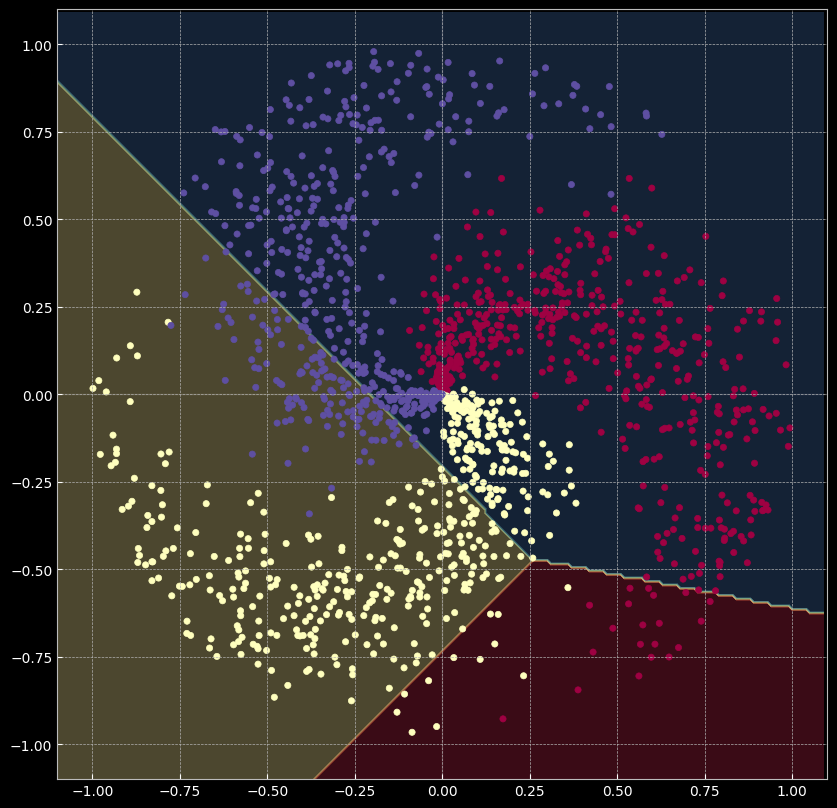

In [10]:
# Plot trained model
print(linear_model)
plot_model(X, y, linear_model)

### Numerical test results for a hidden-layered network with an activation function

Activation functions in PyTorch can be found in the website [Non-linear Activations](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity) and [the others](https://pytorch.org/docs/stable/nn.html#non-linear-activations-other). Here are the test results produced by using typical atication functions:

- [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=nn%20relu#torch.nn.ReLU)
```
[EPOCH]: 0, [LOSS]: 1.111339, [ACCURACY]: 0.333
[EPOCH]: 15, [LOSS]: 0.104682, [ACCURACY]: 0.953
Training the nonlinear model takes 0.0617 seconds
```

- [RELU6](https://pytorch.org/docs/stable/generated/torch.nn.ReLU6.html)
```
[EPOCH]: 0, [LOSS]: 1.103714, [ACCURACY]: 0.194
[EPOCH]: 17, [LOSS]: 0.081547, [ACCURACY]: 0.975
Training the nonlinear model takes 0.0731 seconds
```

- [RRELU](https://pytorch.org/docs/stable/generated/torch.nn.RReLU.html)
```
[EPOCH]: 0, [LOSS]: 1.119960, [ACCURACY]: 0.319
[EPOCH]: 16, [LOSS]: 0.086450, [ACCURACY]: 0.963
Training the nonlinear model takes 0.0866 seconds
```

- [SELU](https://pytorch.org/docs/stable/generated/torch.nn.SELU.html)
```
[EPOCH]: 0, [LOSS]: 1.155280, [ACCURACY]: 0.333
[EPOCH]: 14, [LOSS]: 0.125699, [ACCURACY]: 0.952
Training the nonlinear model takes 0.0688 seconds
```
- [CELU](https://pytorch.org/docs/stable/generated/torch.nn.CELU.html)
```
[EPOCH]: 0, [LOSS]: 1.129845, [ACCURACY]: 0.105
[EPOCH]: 14, [LOSS]: 0.135331, [ACCURACY]: 0.959
Training the nonlinear model takes 0.0695 seconds
```

- [GELU](https://pytorch.org/docs/stable/generated/torch.nn.GELU.html)
```
[EPOCH]: 0, [LOSS]: 1.110101, [ACCURACY]: 0.333
[EPOCH]: 15, [LOSS]: 0.132183, [ACCURACY]: 0.951
Training the nonlinear model takes 0.0720 seconds
```

- [SIGMOID](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html)
```
[EPOCH]: 0, [LOSS]: 1.150436, [ACCURACY]: 0.333
[EPOCH]: 64, [LOSS]: 0.161114, [ACCURACY]: 0.963
Training the nonlinear model takes 0.2528 seconds
```

- [TANH](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html)
```
[EPOCH]: 0, [LOSS]: 1.103973, [ACCURACY]: 0.203
[EPOCH]: 13, [LOSS]: 0.114222, [ACCURACY]: 0.958
Training the nonlinear model takes 0.0603 seconds
```

- [SOFTPLUS](https://pytorch.org/docs/stable/generated/torch.nn.Softplus.html): A smooth approximation to the ReLU function and can be used to constrain the output of a machine to always be positive.
```
[EPOCH]: 0, [LOSS]: 1.158936, [ACCURACY]: 0.333
[EPOCH]: 42, [LOSS]: 0.215517, [ACCURACY]: 0.951
Training the nonlinear model takes 0.2650 seconds
```

- [SOFTMIN](https://pytorch.org/docs/stable/generated/torch.nn.Softmin.html)
```
[EPOCH]: 0, [LOSS]: 1.116268, [ACCURACY]: 0.333
[EPOCH]: 63, [LOSS]: 0.264826, [ACCURACY]: 0.950
Training the nonlinear model takes 0.2988 seconds
```

- [SOFTMAX](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html)
```
[EPOCH]: 0, [LOSS]: 1.099186, [ACCURACY]: 0.333
[EPOCH]: 63, [LOSS]: 0.162910, [ACCURACY]: 0.951
Training the nonlinear model takes 0.2932 seconds
```

- [LogSoftmax](https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html)
```
[EPOCH]: 0, [LOSS]: 2.095248, [ACCURACY]: 0.333
[EPOCH]: 85, [LOSS]: 0.173697, [ACCURACY]: 0.957
Training the nonlinear model takes 0.3926 seconds
```



## Implementing Simple Activation Functions
The most simple activation functions
* are differentiable and don't need the manual implementation of the backward step,
* don't have any trainable parameters, all their parameters are set in advance.

One of the examples of such simple functions is Sigmoid Linear Unit or just [SiLU](https://arxiv.org/pdf/1606.08415.pdf) also known as Swish-1:

$$SiLU(x) = x * \sigma(x) = x * \frac{1}{1 + e^{-x}}$$

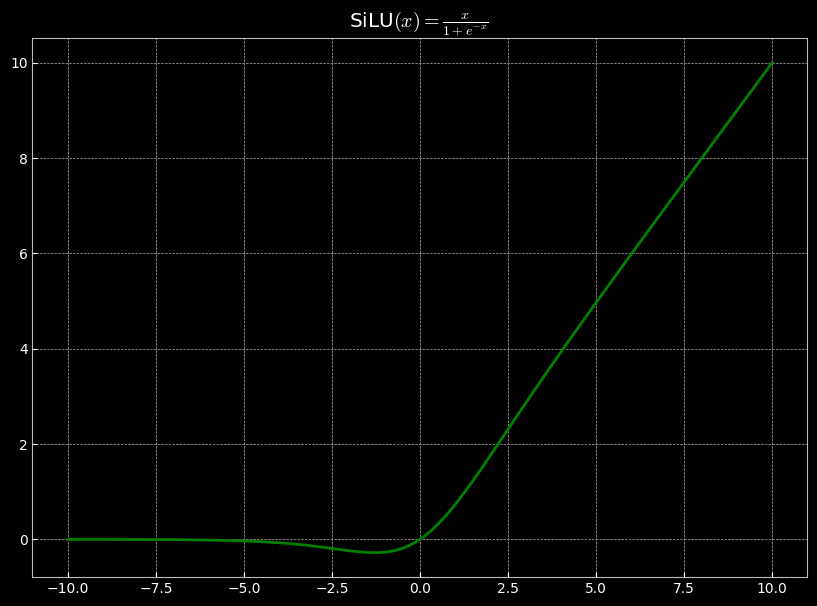

In [33]:
# Plot this function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig = plt.figure(figsize=(10,7))
ax = plt.axes()

plt.title(r"SiLU$(x) =  \frac{x}{1 + e^{-x}}$ ")

xx = np.linspace(-10, 10, 100)
ax.plot(xx, xx * sigmoid(xx), '-g');

In [34]:
# simply define a silu function
def silu(input):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:

        SiLU(x) = a * x * sigmoid(x)
    '''
    return input * torch.sigmoid(input) # use torch.sigmoid to make sure that we created the most efficient implemetation based on builtin PyTorch functions

# create a class wrapper from PyTorch nn.Module, so
# the function now can be easily used in models
class SiLU(nn.Module):
    '''
    Applies the Sigmoid Linear Unit (SiLU) function element-wise:
    
        SiLU(x) = x * sigmoid(x)

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    References:
        -  Related paper:
        https://arxiv.org/pdf/1606.08415.pdf

    Examples:
        >>> m = silu()
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self):
        '''
        Init method.
        '''
        super().__init__() # init the base class

    def forward(self, input):
        '''
        Forward pass of the function.
        '''
        print("Use SiLU function")
        return silu(input) # simply apply already implemented SiLU

In [35]:
# Create a modified SiLU with a parameter a
class mSiLU(nn.Module):
    '''
    Define a modified Sigmoid Linear Unit (SiLU) function element-wise:
    
        mSiLU(x) = a * x * sigmoid(x)
        
    where a is a scale parameter to control the approximation of SiLU to ReLU.

    Shape:
        - Input: (N, *) where * means, any number of additional
          dimensions
        - Output: (N, *), same shape as the input

    Examples:
        >>> m = mSiLU(2.0)  # with a = 2.0
        >>> input = torch.randn(2)
        >>> output = m(input)

    '''
    def __init__(self, a = 1.0):
        super().__init__()
        self.a = a  # or torch.tensor(a)

    def forward(self, x):
        '''
        Forward pass of the function.
        '''
        print("Input type:", type(x))
        y = self.a * x * torch.sigmoid(x)
        print("y type:", type(y))
        print("y = ",y)
        return y

In [15]:
class mReLU(nn.Module):
# To define a new Class we must include __init__ and forward
# Note: we define h in the init function below
    def __init__(self, h=.5): 
        super(mReLU, self).__init__()
        self.h = h

    def forward(self, x):
        h=self.h
        y = torch.zeros(x.shape)
        z = torch.where(x>h, x, torch.where(x<-h, y, 1/(4*h)*x*x + 1/2*x + 1/4*h))
        return z

'''
import torch.nn.functional as F

class mReLU(nn.Module):
    def __init__(self, h=0.5):
        super(mReLU, self).__init__()
        self.h = h
        self.leaky_relu = nn.LeakyReLU(1 / (4 * h))

    def forward(self, x):
        relu_output = F.relu(x)
        negative_output = -1 * self.leaky_relu(-1 * x)
        return relu_output + negative_output - self.h

'''

Text(0, 0.5, 'y')

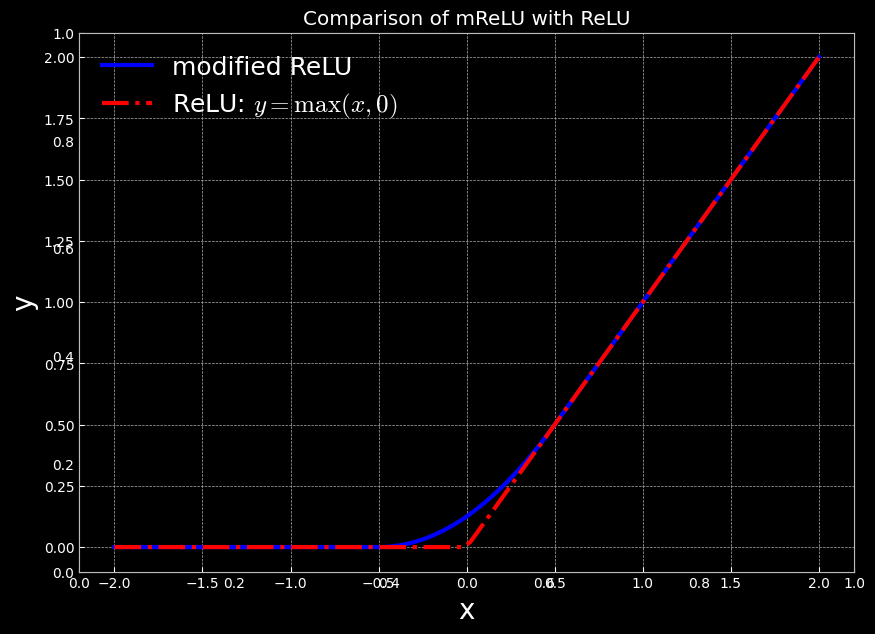

In [22]:
# Plot the function
fig = plt.figure(figsize=(10,7))
ax = plt.axes()

mrelu = mReLU(0.50)
relu = nn.ReLU()

x = torch.linspace(-2, 2, 100)
# Plot the ReLU function
ax = plt.axes()
ax.plot(x, mrelu(x),label = 'modified ReLU', linestyle='-', color='b', linewidth=3)
ax.plot(x, relu(x), label = 'ReLU: $y = \max(x, 0)$', linestyle='-.', color='r', linewidth=3)
plt.legend(loc='upper left',fontsize=18, framealpha=0.0)


plt.title("Comparison of mReLU with ReLU")
plt.xlabel("x", fontsize=20)
plt.ylabel("y", fontsize=20)

### Test results

- Use SiLU:

[EPOCH]: 16, [LOSS]: 0.109319, [ACCURACY]: 0.967

Training the nonlinear model takes 0.0360 seconds

- Use mSiLU(a) with a = 2.0

[EPOCH]: 12, [LOSS]: 0.176474, [ACCURACY]: 0.963
Training the nonlinear model takes 0.0348 seconds

In [46]:
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
#activation_function = nn.ReLU()
#activation_function = SiLU()
#activation_function = mSiLU(5.0)
activation_function = mReLU(0.2)

N = 500  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 20  # number of neuros of the first hidden layer
H2 = 10  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer

model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.1
lambda_l2 = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 500
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

'''
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
#activation_function = nn.ReLU()
#activation_function = SiLU()
#activation_function = mSiLU(5.0)
activation_function = nn.LeakyReLU()

N = 1000  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 50  # number of neuros of the first hidden layer
H2 = 30  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10  # number of neuros of the fourth hidden layer

model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, H4),
    activation_function,
    nn.Linear(H4, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# ADAM for our parameter updates
learning_rate = 0.01
lambda_l2 = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 1000
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")
'''

'''
# nn package to create our linear model
# each Linear module has a weight and bias
# Note: Increasing the number of hidden layers can make the predicted function become more nonlinear
#       so that the prediction accuracy can be further improved. 
#activation_function = nn.ReLU()
#activation_function = SiLU()
#activation_function = mSiLU(5.0)
activation_function = nn.LeakyReLU()

N = 1000  # number of sample points in each subdomain D_i
D = 2  # dimensions
C = 3  # number of sub-classes
H1 = 50  # number of neuros of the first hidden layer
H2 = 30  # number of neuros of the second hidden layer
H3 = 10  # number of neuros of the third hidden layer
H4 = 10  # number of neuros of the fourth hidden layer

model = nn.Sequential(
    nn.Linear(D, H1),
    activation_function,
    nn.Linear(H1, H2),
    activation_function,
    nn.Linear(H2, H3),
    activation_function,
    nn.Linear(H3, H4),
    activation_function,
    nn.Linear(H4, C)
)
model.to(device)

# nn package also has different loss functions.
# we use cross entropy loss for our classification task
Loss = torch.nn.CrossEntropyLoss()

# we use the optim package to apply
# Adagrad for our parameter updates
learning_rate = 0.01
lambda_l2 = 1e-4
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate, weight_decay=lambda_l2)

# e = 1.  # plotting purpose

# Training
eps = 0.95
IteMax = 1000
length4y = len(y)
acc = 0.0
ite = 0

# Start the timer by perf_counter(), which measures the time in seconds from this moment 
tic = time.perf_counter()

while acc < eps and ite < IteMax:
    
    # Get the predicted value y_pred of the target function value y at the input data X
    y_pred = model(X)
    
    # Compute the loss and accuracy
    loss = Loss(y_pred, y)
    score, predicted = torch.max(y_pred, 1)
    acc = (y == predicted).sum().float() / len(y)
    print("[EPOCH]: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (ite, loss.item(), acc))
    #display.clear_output(wait=True)
    
    # zero the gradients before running
    # the backward pass.
    optimizer.zero_grad()
    
    # Calculate the gradient vector of the loss function with respect to parameters w
    #  by loss.backward()
    loss.backward()
    
    # Update the parameters w by the grandient descent method
    #  w = w + lr * gradient
    optimizer.step()
    # Increase the number of iteration by 1
    ite += 1

# Set another time counter
toc = time.perf_counter()
# Time cost between tic and toc is toc - tic
print(f"Training the nonlinear model takes {toc - tic:0.4f} seconds")

'''

[EPOCH]: 0, [LOSS]: 1.116166, [ACCURACY]: 0.333
[EPOCH]: 1, [LOSS]: 1.055184, [ACCURACY]: 0.331
[EPOCH]: 2, [LOSS]: 0.951974, [ACCURACY]: 0.352
[EPOCH]: 3, [LOSS]: 0.771202, [ACCURACY]: 0.721
[EPOCH]: 4, [LOSS]: 0.566261, [ACCURACY]: 0.801
[EPOCH]: 5, [LOSS]: 0.452432, [ACCURACY]: 0.871
[EPOCH]: 6, [LOSS]: 0.649453, [ACCURACY]: 0.749
[EPOCH]: 7, [LOSS]: 0.399045, [ACCURACY]: 0.829
[EPOCH]: 8, [LOSS]: 0.524626, [ACCURACY]: 0.814
[EPOCH]: 9, [LOSS]: 0.354816, [ACCURACY]: 0.866
[EPOCH]: 10, [LOSS]: 0.386802, [ACCURACY]: 0.851
[EPOCH]: 11, [LOSS]: 0.385205, [ACCURACY]: 0.858
[EPOCH]: 12, [LOSS]: 0.372863, [ACCURACY]: 0.873
[EPOCH]: 13, [LOSS]: 0.314620, [ACCURACY]: 0.883
[EPOCH]: 14, [LOSS]: 0.309737, [ACCURACY]: 0.878
[EPOCH]: 15, [LOSS]: 0.301659, [ACCURACY]: 0.865
[EPOCH]: 16, [LOSS]: 0.286742, [ACCURACY]: 0.872
[EPOCH]: 17, [LOSS]: 0.257216, [ACCURACY]: 0.907
[EPOCH]: 18, [LOSS]: 0.234311, [ACCURACY]: 0.924
[EPOCH]: 19, [LOSS]: 0.236727, [ACCURACY]: 0.909
[EPOCH]: 20, [LOSS]: 0.237817,

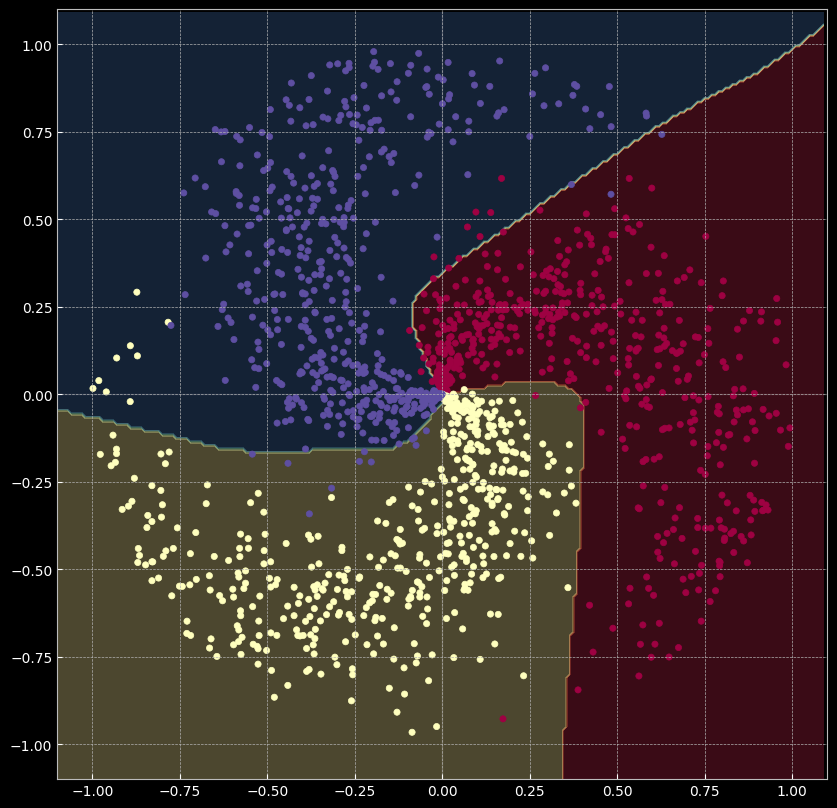

In [19]:
plot_model(X, y, model)

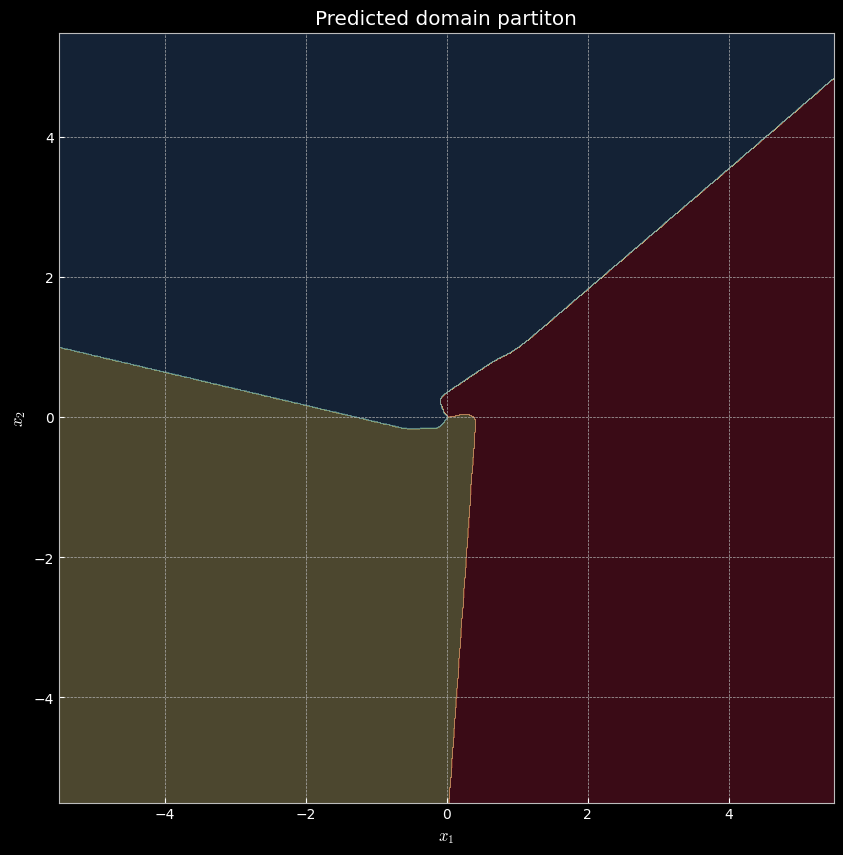

In [20]:
plot_model2(X, y, model)

## Test results

- By Adam: [EPOCH]: 33, [LOSS]: 0.146479, [ACCURACY]: 0.957  with learning_rate = 1e-1
- - By Adam: [EPOCH]: 75, [LOSS]: 0.185647, [ACCURACY]: 0.950 with learning_rate = 1e-2
- By SGD: [EPOCH]: 499, [LOSS]: 0.252418, [ACCURACY]: 0.921 with learning_rate = 1e-1
- By SGD: [EPOCH]: 308, [LOSS]: 0.206772, [ACCURACY]: 0.951 with learning_rate = 0.5

## Selection of an optimiation algorithm from Pytorch

[torch.optim](https://pytorch.org/docs/stable/optim.html#module-torch.optim) is a package implementing various optimization algorithms. For example, we have used

- optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,  weight_decay=lambda_l2) 
- optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

## Selection of loss function in Pytorch

- [cross entropy loss tutorial](https://towardsdatascience.com/cross-entropy-loss-function-f38c4ec8643e)
- [Pytorch document on CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [21]:
for param in model.parameters():
    print(param.size())
    print(type(param.data))

torch.Size([20, 2])
<class 'torch.Tensor'>
torch.Size([20])
<class 'torch.Tensor'>
torch.Size([10, 20])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>
torch.Size([10, 10])
<class 'torch.Tensor'>
torch.Size([10])
<class 'torch.Tensor'>
torch.Size([3, 10])
<class 'torch.Tensor'>
torch.Size([3])
<class 'torch.Tensor'>


In [22]:
# Construct a training data set D ={ (x_1, y_1), (x_2, y_2), (x_3, y_3)}
#  with x_i: Row i of the input tensor of 3 by 5
#       y_i: Entry i of the target tensor of 3 
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print('input: ', input)
print('target: ', target)

# Select the loss function as the Cross-Entropy loss function
cross_entropy_loss = nn.CrossEntropyLoss()

# 
output = cross_entropy_loss(input, target)

# Computes the gradient of current tensor w.r.t. graph leaves.
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[ 0.8750,  0.8132, -0.0257,  0.7239,  0.9716],
        [-0.7232, -0.1933,  0.2199,  0.2352, -1.9756],
        [-0.3891, -1.2697, -1.1197, -1.4445,  1.2958]], requires_grad=True)
target:  tensor([1, 2, 0])
input:  tensor([[ 0.8750,  0.8132, -0.0257,  0.7239,  0.9716],
        [-0.7232, -0.1933,  0.2199,  0.2352, -1.9756],
        [-0.3891, -1.2697, -1.1197, -1.4445,  1.2958]], requires_grad=True)
target:  tensor([1, 2, 0])
output:  tensor(1.5704, grad_fn=<NllLossBackward0>)
